In [334]:
import tensorflow as tf
tf.__version__

'2.3.1'

In [335]:
import glob # The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order.
import imageio # Imageio is a Python library that provides an easy interface to read and write a wide range of image data, including animated images, volumetric data, and scientific formats.
# Magic function - sets the output of plotting commands to inline so that the output is below the jupiter cell
%matplotlib inline
import matplotlib.pyplot as plt
import os
import tensorflow.keras.layers as layers # Keras layers API
import time
from IPython import display # For displaying image

In [349]:
import numpy as np

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import PIL

DATA_DIR = "../datasets/processed-celeba-small/processed_celeba_small/"
IMG_HEIGHT = 64
IMG_WIDTH = 64

def load_image( infilename ) :
    img = PIL.Image.open( infilename )
    img = img.crop([25,65,153,193])
    img = img.resize((64,64))
    data = np.asarray( img, dtype="int32" )
    return data

train_images = np.array(os.listdir(DATA_DIR))
np.random.shuffle(train_images)
BUFFER_SIZE = 100#200000 # number of images in training i think
BATCH_SIZE = 5#500 # This is just the standard number for batch size. Google for more info
# shuffle and batch the data
np.random.shuffle(train_images)
train_images = np.split(train_images[:BUFFER_SIZE],BATCH_SIZE)

ValueError: array split does not result in an equal division

In [337]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))

    model.add(layers.BatchNormalization())

    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 1024)))
    assert model.output_shape == (None, 4, 4, 1024)

    model.add(layers.Conv2DTranspose(512, (5, 5), strides = (2,2), padding = "same", use_bias = False))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Another transposed convolutional layer (upsampling)
    model.add(layers.Conv2DTranspose(256, (5,5), strides = (2,2), padding = "same", use_bias = False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Another transposed convolutional layer (upsampling)
    model.add(layers.Conv2DTranspose(128, (5,5), strides = (2,2), padding = "same", use_bias = False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Final output layer also a convolutional layer (upsampling), sigmoid goes from 0 to 1
    model.add(layers.Conv2DTranspose(3, (5,5), strides = (2,2), padding = "same", use_bias = False, activation = "sigmoid"))
    assert model.output_shape == (None, 64, 64, 3)

    return model

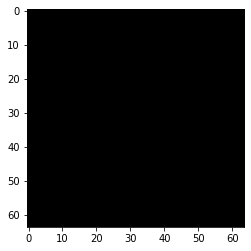

In [338]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0], interpolation='nearest')

In [339]:
def make_discriminator_model():
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[64,64,3]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [340]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-2.0487519e-06]], shape=(1, 1), dtype=float32)


In [341]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [342]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [343]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [344]:
EPOCHS = 60
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [345]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [346]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [347]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i])
      plt.axis('off')

  if not os.path.exists('images'):
    os.makedirs('images')
  plt.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

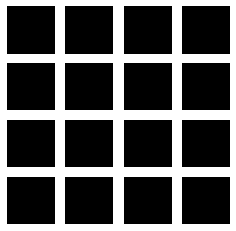

Time for epoch 1 is 50.4012086391449 sec


KeyboardInterrupt: 

In [348]:
train(train_dataset, EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('images/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)